In [ ]:
!pip install diffusers["torch"] transformers
!pip install diffusers["flax"] transformers
!pip install omegaconf
# !pip install transfomers
!pip install transformers==4.31.0 diffusers invisible-watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=f04b67fecc42406ec48e5b9b525fe99b9ec8b44a64b9a5cf3022d44d07b4c551
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
import itertools
import typing as typ
import math
import os.path
import random
import cv2
import diffusers
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, StableDiffusionPipeline
from diffusers.utils import load_image
from tqdm import tqdm
from PIL import Image
import numpy as np

# from read_lora import load_lora_weights_orig
# from set_seed import seed_everything


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
moaw_dir: str = "/content/drive/MyDrive/input_images"
out_dir: str = "/content/drive/real2anime"

def get_canny_image(filename: str) -> Image:
    """Return canny image."""
    image = load_image(filename)
    image = np.array(image)
    low_threshold = 100
    high_threshold = 200
    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)
    return canny_image

base_prompts: typ.List[str] = [
    # "painting",
    # "drawing",
    # "sketching",
    # "oil paint",
    # "water colour picture",
    "anime",
]

pictures = [

    ("output", f"{moaw_dir}/1.png"),
]
models = [
    # ("CuteYukiMix", "/content/drive/MyDrive/saved_models/cuteyukimixAdorable_specialchapter"),
    ("Flat 2D Image", "/content/drive/MyDrive/saved_models/flat2DAnimerge_v40"),

]



In [ ]:
guess_modes = [
    # True, NotImplementedError: The operator 'aten::logspace.out' is not currently implemented for the MPS device
    False
]
combined_list = list(itertools.product(
    base_prompts,
    pictures,
    models,
    guess_modes,
    )
)
random.shuffle(combined_list)

for item in tqdm(combined_list, total=len(combined_list)):
    base, (desc, image_path), (model_name, model_path), guess_mode = item
    # prompt: str = f"{base}, {desc}"
    prompt: str = f""
    filename: str = f"{out_dir}/MyDrive/{base}_{desc}_{model_name}_{guess_mode}.png"
    if not os.path.exists(filename):
        print(filename)
        controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny").to("cuda")

        pipe = StableDiffusionControlNetPipeline.from_single_file(
            "/content/drive/MyDrive/saved_models/flat2DAnimerge_v40.safetensors",
            controlnet=controlnet,
            requires_safety_checker=False,
            safety_checker=None
        )

        pipe = pipe.to("cuda")
        factor: float = 1
        init_image = get_canny_image(image_path)
        width, height = init_image.size
        new_width: int = math.floor(factor * width)
        new_height: int = math.floor(factor * height)
        init_image = init_image.resize((new_width, new_height))
        images = pipe(prompt=prompt,
                      negative_prompt="realistic",
                      image=init_image,
                      guidance_scale=10,
                      guess_mode=guess_mode).images[0]
        # generator = torch.Generator("cuda").manual_seed(1024)
        # image = pipe(prompt, negative_prompt="realistic", num_inference_steps=15, generator=generator).images[0]

        print("About to display!!!!!!!!")
        images
        images.save(f"/content/drive/MyDrive/real2anime/output5.png")

    else:
        print(f"{filename} exist")

  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/real2anime/MyDrive/anime_output_Flat 2D Image_False.png


config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:42<00:00, 102.11s/it]

About to display!!!!!!!!


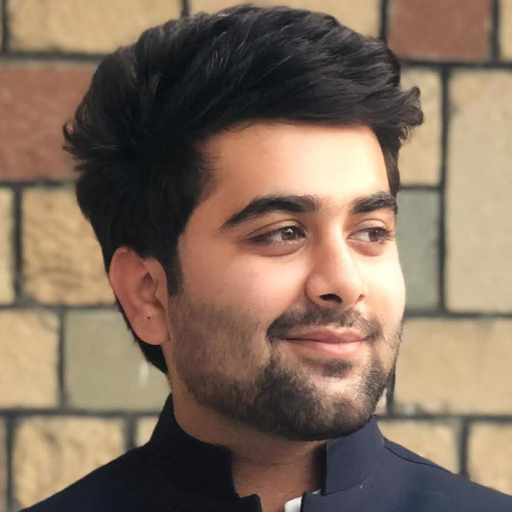

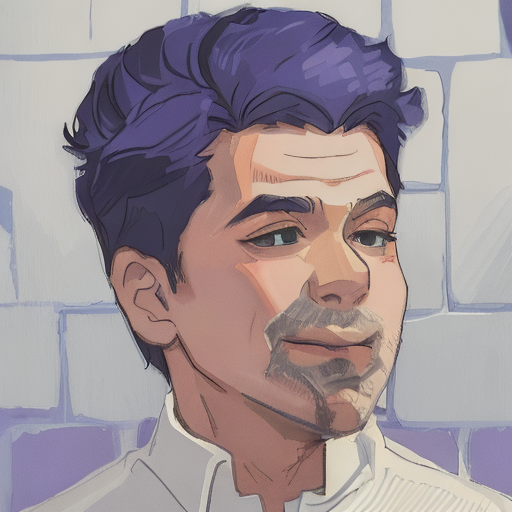

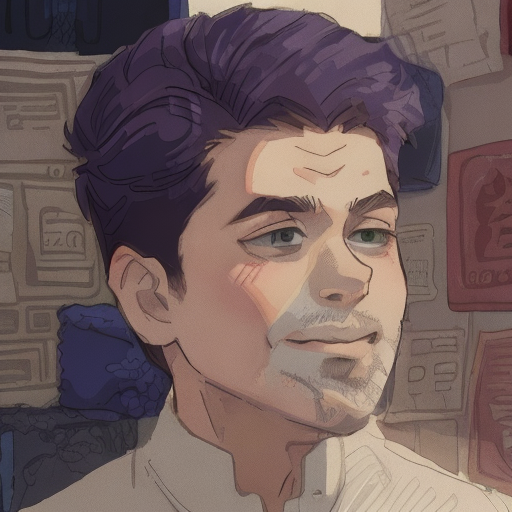

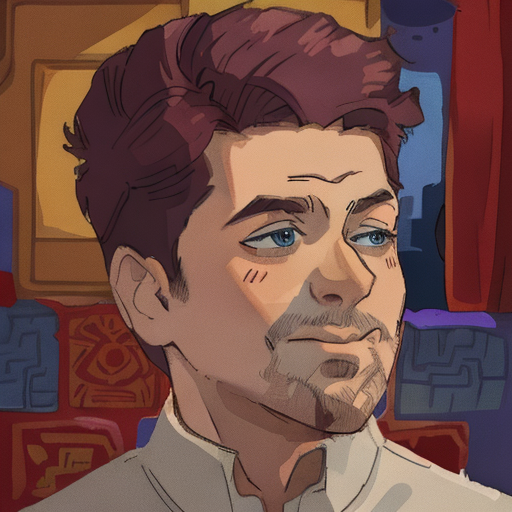

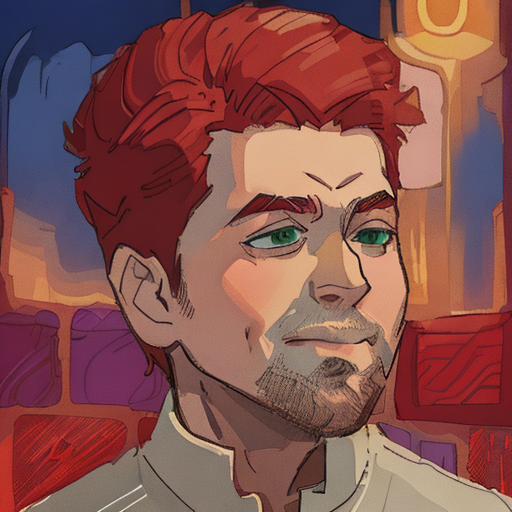

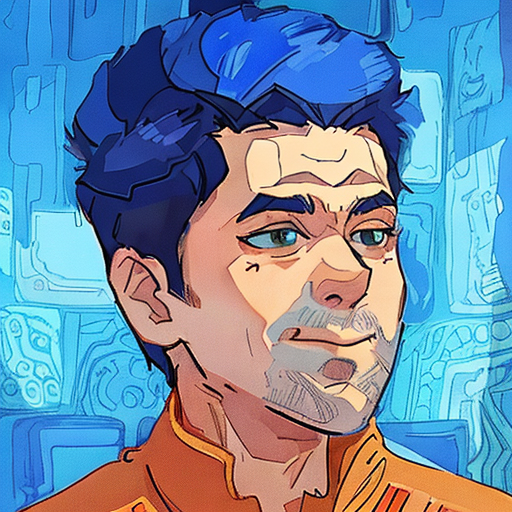

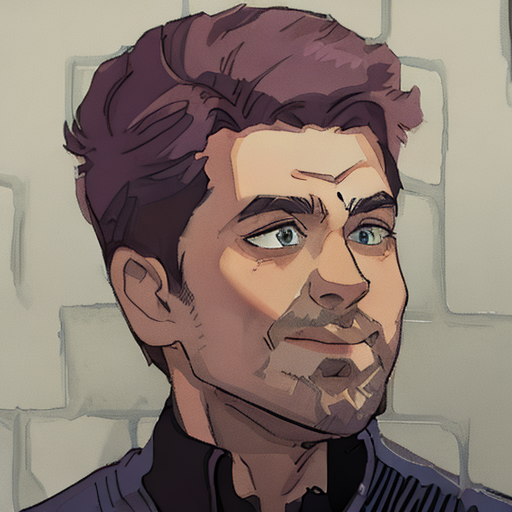

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/drive/MyDrive/input_images/1.png")
cv2_imshow(img)

# guidance 7.5
img = cv2.imread("/content/drive/MyDrive/real2anime/output.png")
cv2_imshow(img)

# guidance 7.5
img = cv2.imread("/content/drive/MyDrive/real2anime/output1.png")
cv2_imshow(img)

# guidance 10
img = cv2.imread("/content/drive/MyDrive/real2anime/output2.png")
cv2_imshow(img)

# guidance 11.5
img = cv2.imread("/content/drive/MyDrive/real2anime/output4.png")
cv2_imshow(img)

# guidance 12.5
img = cv2.imread("/content/drive/MyDrive/real2anime/output3.png")
cv2_imshow(img)

images